# Molecular Similarity

<a href="https://colab.research.google.com/github/warwickdatascience/subject-examples/blob/master/python/chemistry/chemistry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

### Problem Statement

Drug development is costly and time-consuming, with a high failure rate. We therefore want to be able to virtually screen molecules to find those that have a high probability of having desirable properties. One simple approach is to start from a target molecule and search through a large database of molecules to find those that have a high degree of chemical similarity. Specifically, we can take a database of molucular [SMILES strings](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) (a text representation of a molucule's structure), encode these into a practical representation of the molecule known as a fingerprint, and search for close matches using a similarity metric. This allows us to screen thousands of molecules with little, to then direct the attention of chemists to promising candidates.

### Resources

Our database of SMILES was taken from [ChEMBL](https://www.ebi.ac.uk/chembl/g/#search_results/compounds/state=eyJsaXN0c19zdGF0ZXMiOnsiQ09NUE9VTkQiOnsic2V0dGluZ3NfcGF0aCI6IkVTX0lOREVYRVMuQ09NUE9VTkQiLCJjdXN0b21fcXVlcnkiOiIqIiwidXNlX2N1c3RvbV9xdWVyeSI6ZmFsc2V9fX0%3D). This provides far too many features, resulting in an incredibly large download. We therefore created a preprocessing script `process_raw_data.py` which takes the entire database and reduces it to around 40,000 name-SMILES pairs which can be found in `smiles.csv`.

### Non-course Techniques

We will take advantage of a package called `rdkit`, a power set of tools for computational chemistry. We also use the package `tqdm` to provide a progress bar for our search.

## Setup

Google Colab does not come with `rdkit` pre-installed. Instead we install it in the following cell only when running this notebook on Colab. **This will take some time** so please be patient.

In [16]:
%%capture
if 'google.colab' in str(get_ipython()):
    !wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
    !chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
    !bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
    !conda install -q -y -c conda-forge rdkit

    import sys
    sys.path.append('/usr/local/lib/python3.7/site-packages/')

We begin by importing any relevant modules and setting the logging parameters for `rdkit`.

In [17]:
from rdkit import Chem, DataStructs, RDLogger
from rdkit.Chem import AllChem, Draw
from tqdm.notebook import tqdm

In [18]:
# Ignore warnings
RDLogger.DisableLog('rdApp.*') 

## Import

We start by reading the pre-processed data into a list of lines.

In [19]:
with open('smiles.csv') as f:
    lines = f.read().split('\n')
    print(lines[0])
    # Remove header and empty final line
    del lines[0]
    del lines[-1]

Name	Smiles


We can then loop through these lines to extract the molecule names and SMILESs

In [20]:
molecules = []
for l in lines:
    elements = l.split('\t')
    molecules.append({
        'name': elements[0],
        'smiles': elements[1]
    })

## Search

We write a function to take a query SMILES string and search through the database for the closest match. To do this, we have to convert the SMILES to an `rdkit` molucule using `Chem.MolFromSmiles` and then calculate a molucular fingerprint using `Chem.RDKFingerprint`. We can then find the similarity of two fingerprints with `DataStructs.FingerprintSimilarity`.

In [21]:
def most_similar(query_smiles):
    max_similarity = 0
    # Transforming the input variable into the necessary format
    query_fp = Chem.RDKFingerprint(Chem.MolFromSmiles(query_smiles))
    # Loop for finding maximum similarity
    for test_mol in tqdm(molecules, desc='Searching database'):
        # Transformating each encountered variable into the necessary format
        test_fp = Chem.RDKFingerprint(Chem.MolFromSmiles(test_mol['smiles']))
        similarity = DataStructs.FingerprintSimilarity(test_fp, query_fp)
        # Similarity has to be lower than 1 to avoid just finding the input variable in the dataset
        if max_similarity < similarity < 1:
            max_similarity = similarity
            best_mol = test_mol
    return best_mol

We can now ask the user for a SMILES string to query and search for the best match.

In [22]:
# E.g. 'OC[C@H]1OC(O)[C@H](O)[C@@H](O)[C@@H]1O' for glucose
query_smiles = input("Input a valid SMILES string:\n")

Input a valid SMILES string:
 OC[C@H]1OC(O)[C@H](O)[C@@H](O)[C@@H]1O


In [23]:
best_mol = most_similar(query_smiles)

In [24]:
print("The best match was:")
print(best_mol['name'])
print(best_mol['smiles'])

The best match was:
L-Fucose
C[C@@H]1OC(O)[C@@H](O)[C@H](O)[C@@H]1O


## Visualisation

Finally, we can visualise the query and best match molecules.

In [25]:
query_m = Chem.MolFromSmiles(query_smiles)
match_m = Chem.MolFromSmiles(best_mol['smiles'])

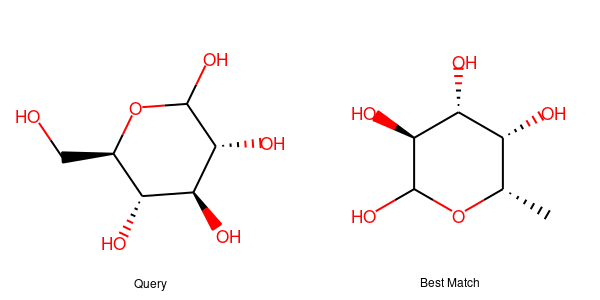

In [27]:
Draw.MolsToGridImage(
    (query_m, match_m),
    legends = ('Query', 'Best Match'),
    molsPerRow=2, subImgSize=(300, 300)
)